In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split   
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix 
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [2]:
jacket = pd.read_excel('data/sizing.xls')
pants = pd.read_excel('data/sizing.xls', sheet_name=1)

In [3]:
jacket_features = jacket[['BehindClothLengthBody', 'FrontClothLengthBody', 'ShoulderWidthBody', 'BustBody', 'AbdomenBody', \
                          'LeftSleeveLengthBody', 'RightSleeveLengthBody', 'WristBody']]
jacket_target = jacket[['BehindClothLengthSetNumber', 'FrontClothLengthSetNumber', 'ShoulderWidthSetNumber', 'BustSetNumber', 'AbdomenSetNumber', \
                       'HemSetNumber', 'LeftSleeveLengthSetNumber', 'RightSleeveLengthSetNumber', 'Wrist finish']]

In [4]:
jacket.replace(0, np.nan, inplace=True)

In [5]:
X = jacket_features.drop(columns=['BehindClothLengthBody', 'RightSleeveLengthBody'])
y = jacket_target.drop(columns=['BehindClothLengthSetNumber', 'FrontClothLengthSetNumber', 'ShoulderWidthSetNumber', \
                                'LeftSleeveLengthSetNumber', 'RightSleeveLengthSetNumber'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.13, random_state=0)

In [7]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = [1,2,3,4,5,6]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': [1, 2, 3, 4, 5, 6],
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [2, 4, 6],
 'n_estimators': [5, 115, 226, 336, 447, 557, 668, 778, 889, 1000]}


In [8]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   53.3s finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': [1, 2, 3, 4, 5, 6],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [5, 115, 226, 336, 447,
                                                         557, 668, 778, 889,
                                                         1000]},
                   random_state=42, verbose=2)

In [9]:
pprint(rf_random.best_params_)
rf_random.best_score_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'n_estimators': 889}


0.4064306957649413

In [10]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: \n{} degrees.'.format(np.mean(errors)))
    print('Accuracy = \n{}%.'.format(accuracy))
    
    return accuracy

In [11]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test);

Model Performance
Average Error: 
BustSetNumber       1.914784
AbdomenSetNumber    2.297803
HemSetNumber        8.457002
Wrist finish        0.690625
dtype: float64 degrees.
Accuracy = 
BustSetNumber       98.369120
AbdomenSetNumber    97.742781
HemSetNumber             -inf
Wrist finish        97.545664
dtype: float64%.


In [12]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test);

Model Performance
Average Error: 
BustSetNumber       2.124010
AbdomenSetNumber    2.502914
HemSetNumber        7.686271
Wrist finish        0.726873
dtype: float64 degrees.
Accuracy = 
BustSetNumber       98.150111
AbdomenSetNumber    97.512582
HemSetNumber             -inf
Wrist finish        97.435669
dtype: float64%.


In [13]:
print('Improvement of \n{}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy));

Improvement of 
BustSetNumber      -0.222640
AbdomenSetNumber   -0.235515
HemSetNumber             NaN
Wrist finish       -0.112762
dtype: float64%.


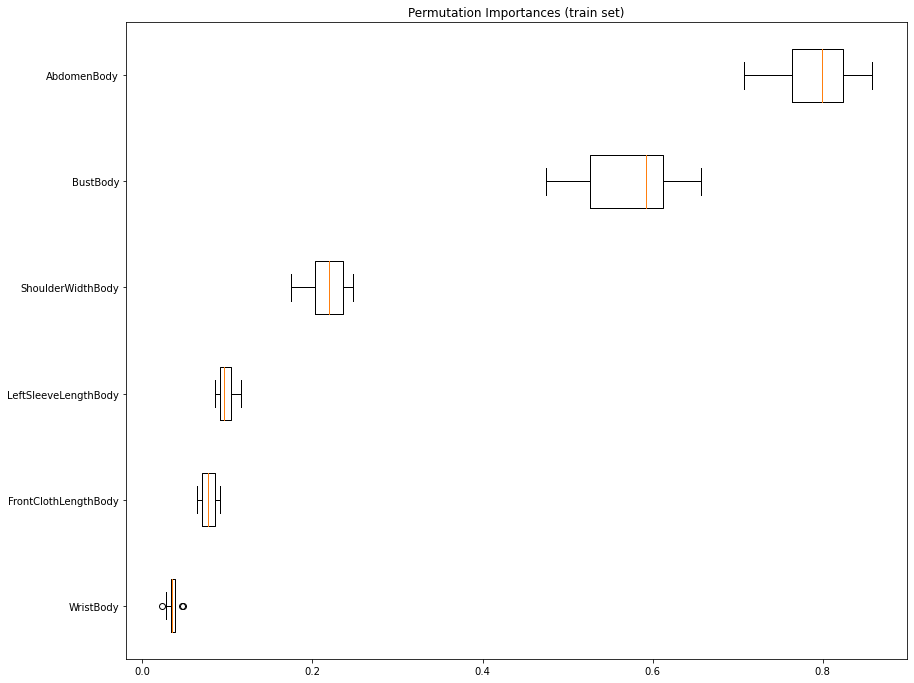

In [14]:
result = permutation_importance(base_model, X_train, y_train, n_repeats=10, random_state=11, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(6.4*2,4.8*2), tight_layout=True)
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
plt.show()

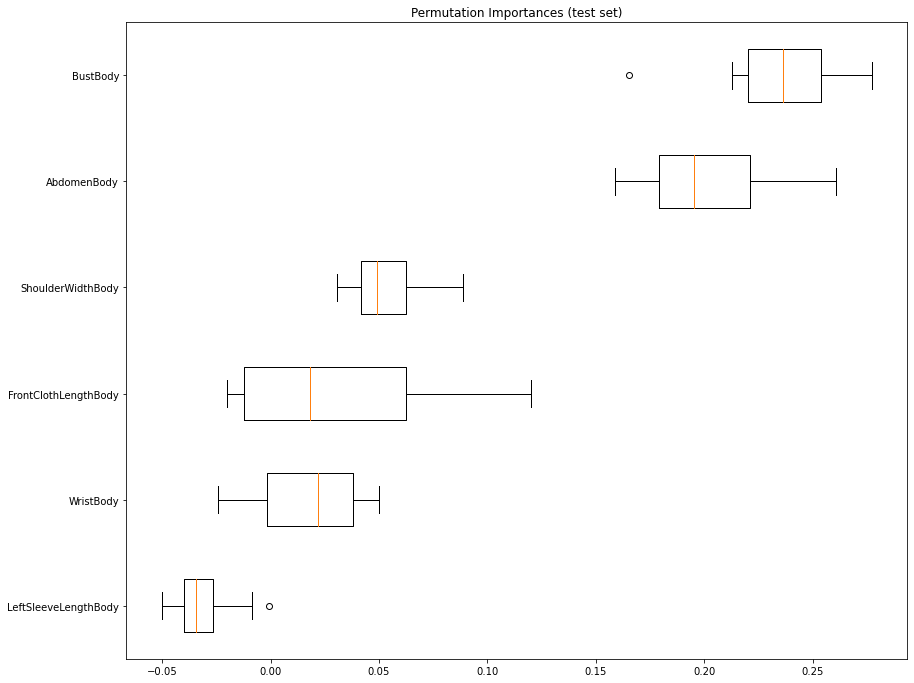

In [15]:
result = permutation_importance(best_random, X_test, y_test, n_repeats=10, random_state=11, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(6.4*2,4.8*2), tight_layout=True)
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
plt.show()

In [16]:
scaler = StandardScaler()
xscaler = scaler.fit(X_train)
X_train_scaled = xscaler.transform(X_train)
X_test_scaled = xscaler.transform(X_test)

yscaler = scaler.fit(y_train)
y_train_scaled = yscaler.transform(y_train)
y_test_scaled = yscaler.transform(y_test)

In [17]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_scaled, y_train_scaled)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   52.2s finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': [1, 2, 3, 4, 5, 6],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [5, 115, 226, 336, 447,
                                                         557, 668, 778, 889,
                                                         1000]},
                   random_state=42, verbose=2)

In [18]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train_scaled, y_train_scaled)
base_accuracy = evaluate(base_model, X_test_scaled, y_test_scaled);

Model Performance
Average Error: 
0.2150059012893094 degrees.
Accuracy = 
30.491332326956183%.


In [19]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_scaled, y_test_scaled);

Model Performance
Average Error: 
0.20653507449618552 degrees.
Accuracy = 
49.99968634012194%.


In [20]:
print('Improvement of \n{}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy));

Improvement of 
63.979998656599186%.


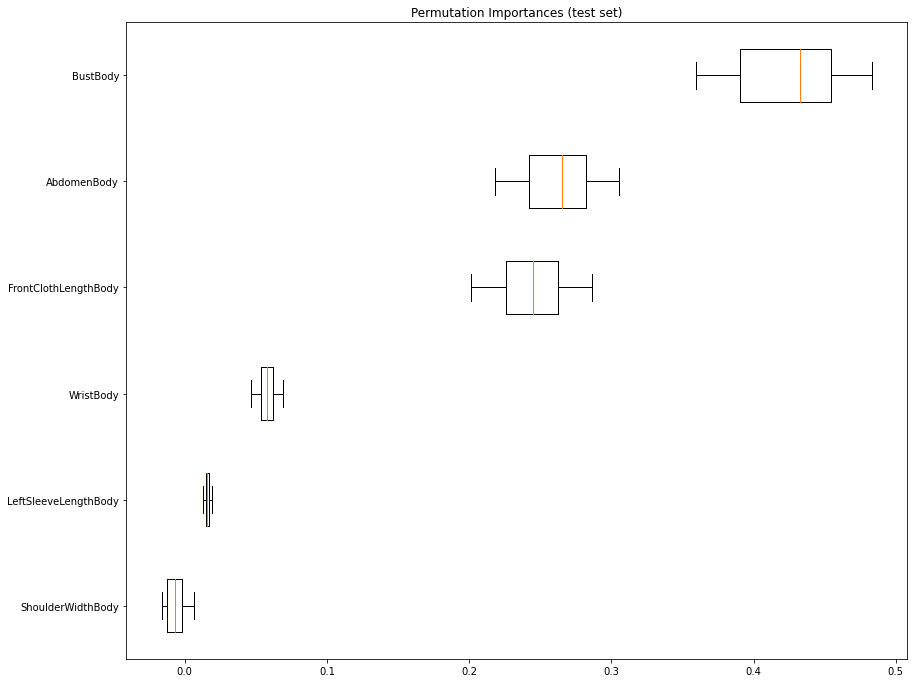

In [21]:
result = permutation_importance(best_random, X_test, y_test, n_repeats=10, random_state=11, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(6.4*2,4.8*2), tight_layout=True)
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
plt.show()

In [22]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler.fit(y_train)
y_train_scaled = scaler.transform(y_train)
y_test_scaled = scaler.transform(y_test)

scaler.fit(X)
X_scaled = scaler.transform(X)

In [23]:
pca = PCA(n_components=5)
pca.fit(X)

PCA(n_components=5)

In [24]:
def scree_plot(ax, pca, n_components_to_plot=8, title=None):
    """Make a scree plot showing the variance explained (i.e. variance
    of the projections) for the principal components in a fit sklearn
    PCA object.
    
    Parameters
    ----------
    ax: matplotlib.axis object
      The axis to make the scree plot on.
      
    pca: sklearn.decomposition.PCA object.
      A fit PCA object.
      
    n_components_to_plot: int
      The number of principal components to display in the scree plot.
      
    title: str
      A title for the scree plot.
    """
    num_components = pca.n_components_
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    ax.plot(ind, vals, color='blue')
    ax.scatter(ind, vals, color='blue', s=50)

    for i in range(num_components):
        ax.annotate(r"{:2.2f}%".format(vals[i]), 
            (ind[i]+0.2, vals[i]+0.005), 
            va="bottom", 
            ha="center", 
            fontsize=12)

    ax.set_xticklabels(ind, fontsize=12)
    ax.set_ylim(0, max(vals) + 0.05)
    ax.set_xlim(0 - 0.45, n_components_to_plot + 0.45)
    ax.set_xlabel("Principal Component", fontsize=12)
    ax.set_ylabel("Variance Explained (%)", fontsize=12)
    if title is not None:
        ax.set_title(title, fontsize=16)
    
    

/Users/joshchow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


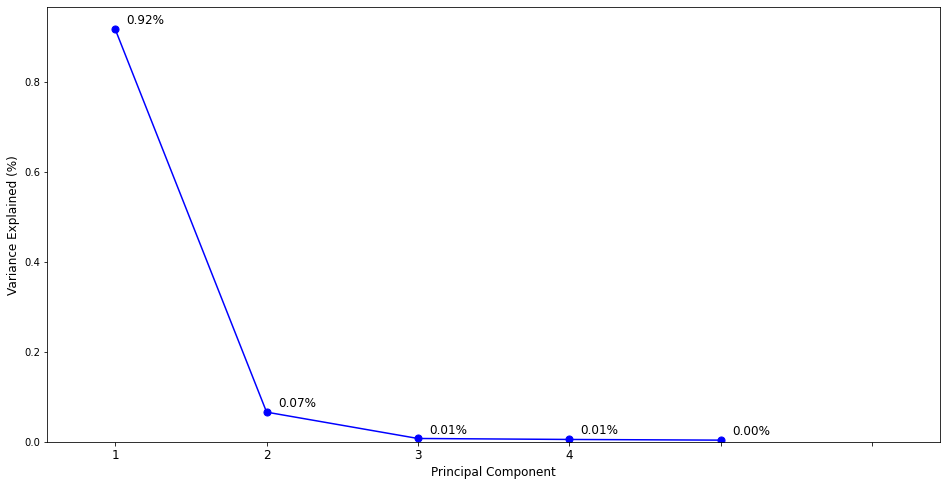

In [25]:
fig, ax = plt.subplots(figsize = (16,8))
scree_plot(ax, pca, n_components_to_plot=5, title=None)

In [26]:
pca.get_covariance()

array([[ 466.33722932,  283.19123308,  645.93006476,  589.95471452,
         364.09062726,  108.79366158],
       [ 283.19123308,  193.25436957,  439.16178097,  399.49001407,
         220.82943266,   67.41834382],
       [ 645.93006476,  439.16178097, 1271.78429466, 1176.4789895 ,
         491.68824691,  158.07859917],
       [ 589.95471452,  399.49001407, 1176.4789895 , 1137.18679709,
         443.55571987,  145.72511294],
       [ 364.09062726,  220.82943266,  491.68824691,  443.55571987,
         300.25699744,   79.56233557],
       [ 108.79366158,   67.41834382,  158.07859917,  145.72511294,
          79.56233557,   39.02431193]])

In [27]:
scores = cross_val_score(rf_random, X_train_scaled, y_train_scaled, cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   47.6s finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   46.1s finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   45.1s finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   49.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   50.2s finished


In [28]:
scores.mean()

0.45641341804703905

In [29]:
from sklearn.tree import DecisionTreeRegressor

In [30]:
dtr = DecisionTreeRegressor()

In [31]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor()

In [32]:
dtr_accuracy = evaluate(dtr, X_test, y_test)

Model Performance
Average Error: 
BustSetNumber       1.958904
AbdomenSetNumber    2.654830
HemSetNumber        7.349561
Wrist finish        0.717000
dtype: float64 degrees.
Accuracy = 
BustSetNumber       98.287537
AbdomenSetNumber    97.291398
HemSetNumber             -inf
Wrist finish        97.431297
dtype: float64%.


In [33]:
base_accuracy

30.491332326956183

In [34]:
random_accuracy

49.99968634012194

In [35]:
random_grid

{'n_estimators': [5, 115, 226, 336, 447, 557, 668, 778, 889, 1000],
 'max_features': [1, 2, 3, 4, 5, 6],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 4, 6],
 'min_samples_leaf': [1, 2, 3],
 'bootstrap': [True, False]}

In [36]:
dtf_grid = {
            'max_depth': max_depth,
            'max_features': max_features,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf}

In [37]:
dtr_random = RandomizedSearchCV(estimator = rf, param_distributions = dtf_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
dtr_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   11.0s finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': [1, 2, 3, 4, 5, 6],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 4, 6]},
                   random_state=42, verbose=2)

In [38]:
dtr_best_random = dtr_random.best_estimator_
dtr_score = evaluate(dtr_best_random, X_test, y_test)

Model Performance
Average Error: 
BustSetNumber       2.193165
AbdomenSetNumber    2.491741
HemSetNumber        7.731683
Wrist finish        0.742808
dtype: float64 degrees.
Accuracy = 
BustSetNumber       98.084773
AbdomenSetNumber    97.506840
HemSetNumber             -inf
Wrist finish        97.376764
dtype: float64%.


In [39]:
base_accuracy

30.491332326956183

In [40]:
random_accuracy

49.99968634012194

In [41]:
dtr_score

BustSetNumber       98.084773
AbdomenSetNumber    97.506840
HemSetNumber             -inf
Wrist finish        97.376764
dtype: float64

Text(0.5, 1.0, 'Accuracy vs Num Trees')

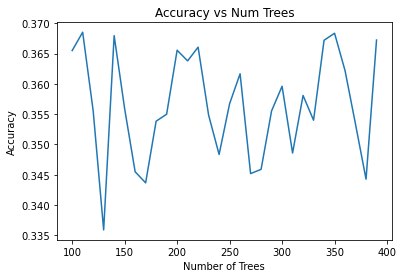

In [43]:
num_trees = range(100, 400, 10)
accuracies = []
for n in num_trees:
    tot = 0
    for i in range(5):
        rf = RandomForestRegressor(n_estimators=n)
        rf.fit(X_train, y_train)
        tot += rf.score(X_test, y_test)
    accuracies.append(tot / 5)
fig, ax = plt.subplots()
ax.plot(num_trees, accuracies)
ax.set_xlabel("Number of Trees")
ax.set_ylabel("Accuracy")
ax.set_title('Accuracy vs Num Trees')

In [45]:
evaluate(rf_random, X_test, y_test)

Model Performance
Average Error: 
BustSetNumber       109.960706
AbdomenSetNumber     96.419324
HemSetNumber        111.717076
Wrist finish         26.993986
dtype: float64 degrees.
Accuracy = 
BustSetNumber       2.822665
AbdomenSetNumber    3.319128
HemSetNumber            -inf
Wrist finish        4.858036
dtype: float64%.


BustSetNumber       2.822665
AbdomenSetNumber    3.319128
HemSetNumber            -inf
Wrist finish        4.858036
dtype: float64

In [47]:
X_train.head()

,FrontClothLengthBody,ShoulderWidthBody,BustBody,AbdomenBody,LeftSleeveLengthBody,WristBody
71,76.0,45.0,107.0,98.0,60.0,17.0
75,80.0,48.0,104.0,93.0,63.0,18.0
320,79.0,46.0,103.0,102.0,61.0,17.5
78,83.0,52.0,124.0,126.0,62.0,19.0
243,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
y_train.head()

,BustSetNumber,AbdomenSetNumber,HemSetNumber,Wrist finish
71,115.0,104.0,114.0,29.0
75,112.0,99.0,113.0,28.5
320,111.0,104.0,126.0,27.5
78,134.0,130.0,148.0,31.0
243,48.0,0.0,108.0,30.0
